In [70]:
%matplotlib notebook 

import os 
import yaml
from argparse import Namespace


import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src/models/')
import network_light as nl
import s_parser as sp
import dataloaders as dl

# from dataloaders import senseiver_dataloader


from importlib import reload

In [2]:
# Specify the path to your YAML file
yaml_file_path = "../src/models/wandb/latest-run/files/config.yaml"

# Open the YAML file and load its contents
with open(yaml_file_path, "r") as yaml_file:
    config = yaml.safe_load(yaml_file)

for key,val in config.items():
    try:
        config[key] = config[key]['value']
    except:
        continue
args = Namespace(**config)
data_config, encoder_config, decoder_config = sp.assign_args(args)

In [68]:
reload(nl)

# model = nl.Senseiver(
#     **encoder_config,
#     **decoder_config,
#     **data_config
# )

# model_id = '3du775z6'
# epoch = 209

model_id = 'swd4mnyz'
epoch = 769

model_id = '9axj36lj'
epoch = 859

model_id = '0okwqqjl'
epoch = 519

model_id = 'c6bg8fyl'
epoch = 59

model_id = 'uh5u02jb'
epoch = 279

model_id = '1pbrlu2t'
epoch = 409

model_id = 'vf13ltyc' # all features, 14 sensors
epoch = 519

# model_id = 'uhhfdhc7' # all features, 8 sensors
# epoch = 309

path_to_checkpoint = f'/Users/z6f/code/ehr-env/src/models/pollution/{model_id}/checkpoints/train-epoch={epoch}.ckpt'

#path_to_checkpoint = f'/Users/z6f/code/ehr-env/src/models/pollution/4zxhr2gf/checkpoints/train-epoch=249.ckpt'

model = nl.Senseiver.load_from_checkpoint(path_to_checkpoint)


"accelerator":                         mps
"accum_grads":                         1
"data_path":                           ../../data/processed/processed_pm25_gridmet.csv
"dec_num_cross_attention_heads":       1
"dec_num_latent_channels":             16
"dec_preproc_ch":                      16
"dropout":                             0.0
"enc_num_latent_channels":             16
"enc_num_self_attention_heads":        2
"enc_preproc_ch":                      16
"gpu_device":                          [0]
"im_ch":                               12
"latent_size":                         1
"load_model_num":                      None
"lr":                                  0.0001
"num_cross_attention_heads":           2
"num_latents":                         256
"num_layers":                          3
"num_queries":                         2
"num_self_attention_layers_per_block": 3
"num_sensors":                         14
"seed":                                123
"space_bands":              

In [30]:
# data_config['data_path'] = '../data/processed/daily_pm_southeast.pickle'
data_config['data_path'] = '../data/processed/processed_pm25_gridmet.csv'
dataloader = senseiver_dataloader(data_config, num_workers=4)
sensors, query_coords, targets = dataloader.dataset[0]
model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))

tensor([[[1.1762],
         [1.2601]]], device='mps:0', grad_fn=<LinearBackward0>)

results senseiver: 
R^2: 0.7089280084333189
MAE: 2.8894588947296143
RMSE: 4.243626117706299
results average: 
R^2: 0.3436961854897497
MAE: 4.516126253058661
RMSE: 6.372199605551176


<IPython.core.display.Javascript object>


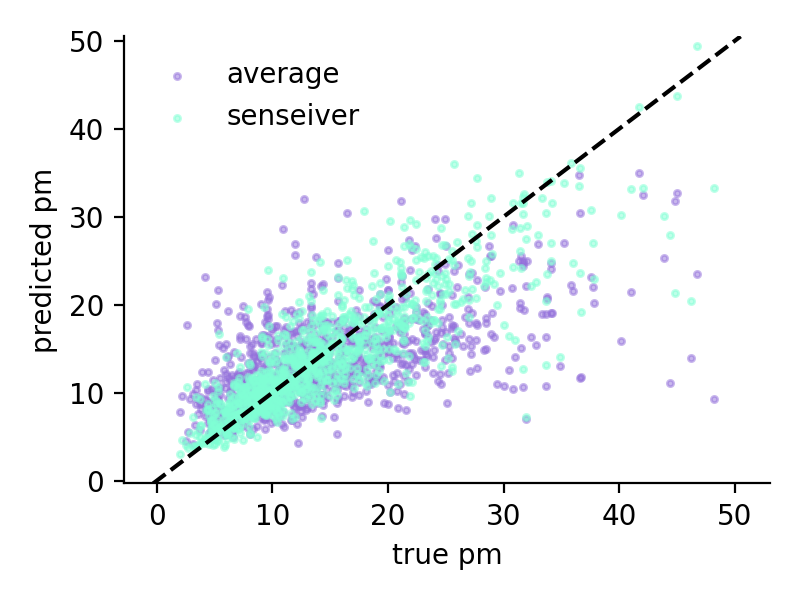

In [77]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
reload(dl)
# data_config['data_path'] = '../data/processed/daily_pm_southeast.pickle'
data_config['data_path'] = '../data/processed/processed_pm25_gridmet.csv'
torch.manual_seed(42)
dataloader = senseiver_dataloader(data_config, num_workers=4)
sensors, query_coords, targets = dataloader.dataset[0]
model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))


all_pred = []
all_targ = []
sensor_means = []
#all_positions = np.array([[0,0,0]])
for i in range(1000):
    with torch.no_grad():
        sensors, query_coords, targets = dataloader.dataset[i]
        query_coords = query_coords[0,:].unsqueeze(0)
        targets = targets[0,:]
        sensor_means+=[sensors[:,0].mean().detach().item()]
        out = model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))
        all_pred += list(out.detach().cpu().numpy().ravel())
        # all_pred += list(out.detach().cpu().numpy().ravel() + sensors[:,0].mean().detach().item())

        # all_targ += list(targets.reshape(2,1).numpy().ravel())
        all_targ += list(targets.numpy().ravel())


all_targ = np.array(all_targ)
all_pred = np.array(all_pred)
sensor_means = np.array(sensor_means)

print('results senseiver: ')
print('R^2: {0}'.format(r2_score(10**all_targ,10**all_pred)))
print('MAE: {0}'.format(mean_absolute_error(10**all_targ,10**all_pred)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(10**all_targ,10**all_pred))))

print('results average: ')
print('R^2: {0}'.format(r2_score(10**all_targ,10**sensor_means)))
print('MAE: {0}'.format(mean_absolute_error(10**all_targ,10**sensor_means)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(10**all_targ,10**sensor_means))))

f,ax = plt.subplots(figsize=(4,3))
ax.scatter(10**all_targ,10**sensor_means, s=5, alpha=.5, c='mediumpurple')

ax.scatter(10**all_targ,10**all_pred, s=5, alpha=.5, c='aquamarine')
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(),ax.get_xlim(),'k--')
ax.set_xlabel('true pm')
ax.set_ylabel('predicted pm')
ax.legend(['average','senseiver'],frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.tight_layout()
       # all_positions = np.vstack([all_positions, sensors[:,1:].detach().cpu().numpy()])
#         f,ax = plt.subplots(figsize=(3,2))
#         ax.scatter(sensors[:,1],sensors[:,2],c='k')
#         ax.scatter(query_coords[:,0],query_coords[:,1],c='r')
# all_positions = all_positions[1:,:]
                            

<IPython.core.display.Javascript object>


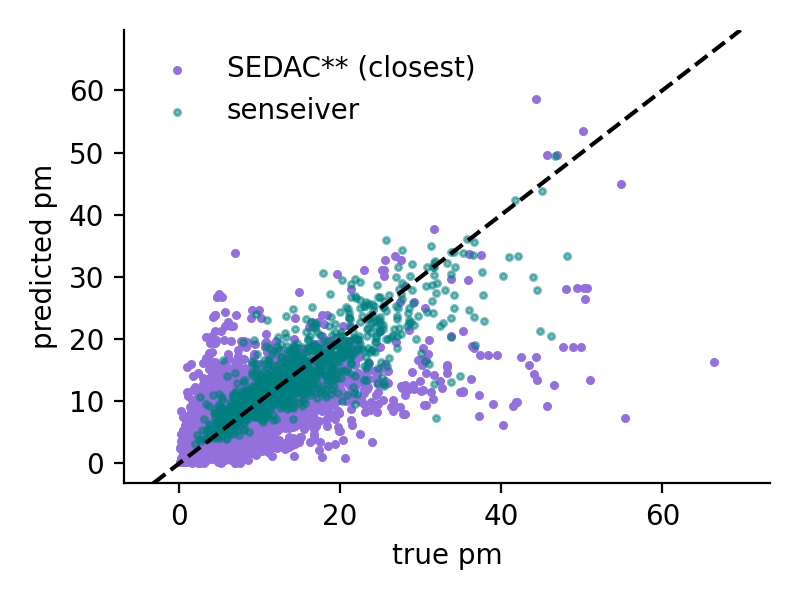

In [82]:
import pandas as pd
# compare to some sedac measurements
sedac = pd.read_csv('/Users/z6f/Desktop/sedac_tmp.csv')
f,ax = plt.subplots(figsize=(4,3))
sedac = sedac[sedac['Conc']>0]
ax.scatter(sedac['Conc'],sedac['SEDAC_PM25'], s=5, c='mediumpurple')
# ax.scatter(10**all_targ,10**sensor_means, s=5, alpha=.5, c='mediumpurple')

ax.scatter(10**all_targ,10**all_pred, s=5, alpha=.5, c='teal')
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(),ax.get_xlim(),'k--')
ax.set_xlabel('true pm')
ax.set_ylabel('predicted pm')
ax.legend(['SEDAC** (closest)','senseiver'],frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.tight_layout()

<IPython.core.display.Javascript object>


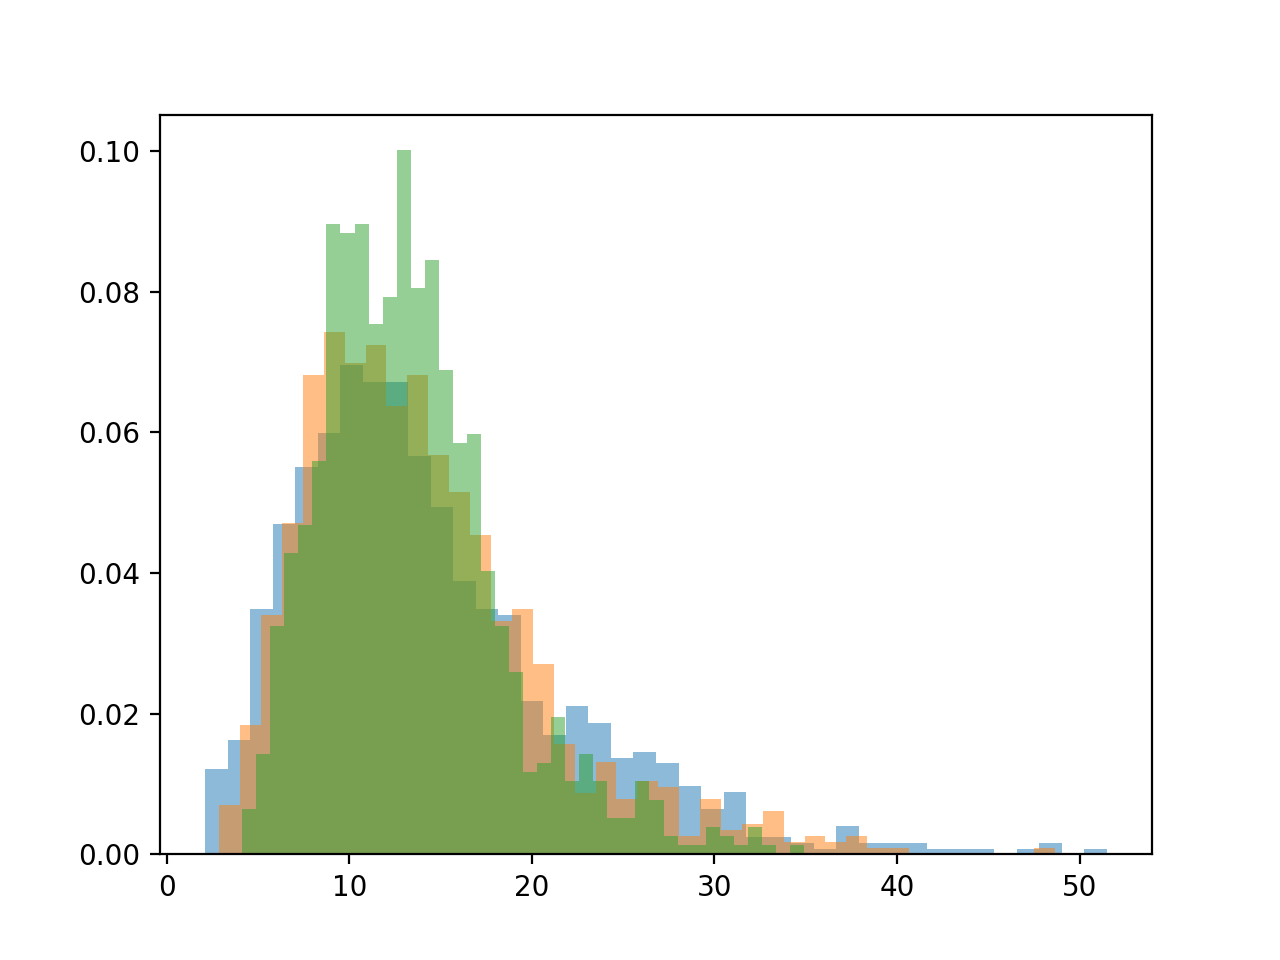

(array([0.0064986 , 0.01429692, 0.03249301, 0.04289077, 0.04678994,
        0.05588798, 0.08968071, 0.08838099, 0.08968071, 0.07538378,
        0.07928295, 0.10007847, 0.08058267, 0.08448183, 0.06888518,
        0.05848742, 0.05978714, 0.04029133, 0.03249301, 0.02599441,
        0.01169748, 0.0129972 , 0.01949581, 0.01039776, 0.01429692,
        0.01039776, 0.00519888, 0.00519888, 0.01039776, 0.00779832,
        0.00259944, 0.00129972, 0.00129972, 0.00389916, 0.00259944,
        0.00129972, 0.00389916, 0.00129972, 0.        , 0.00129972]),
 array([ 4.13004531,  4.89944155,  5.66883778,  6.43823401,  7.20763025,
         7.97702648,  8.74642272,  9.51581895, 10.28521519, 11.05461142,
        11.82400766, 12.59340389, 13.36280013, 14.13219636, 14.90159259,
        15.67098883, 16.44038506, 17.2097813 , 17.97917753, 18.74857377,
        19.51797   , 20.28736624, 21.05676247, 21.82615871, 22.59555494,
        23.36495118, 24.13434741, 24.90374364, 25.67313988, 26.44253611,
        27.21193

In [36]:
f,ax = plt.subplots()
ax.hist(10**np.array(all_targ),bins=40, density=True, alpha=.5)
ax.hist(10**np.array(all_pred),bins=40, density=True, alpha=.5)
ax.hist(10**np.array(sensor_means),bins=40, density=True, alpha=.5)

<IPython.core.display.Javascript object>


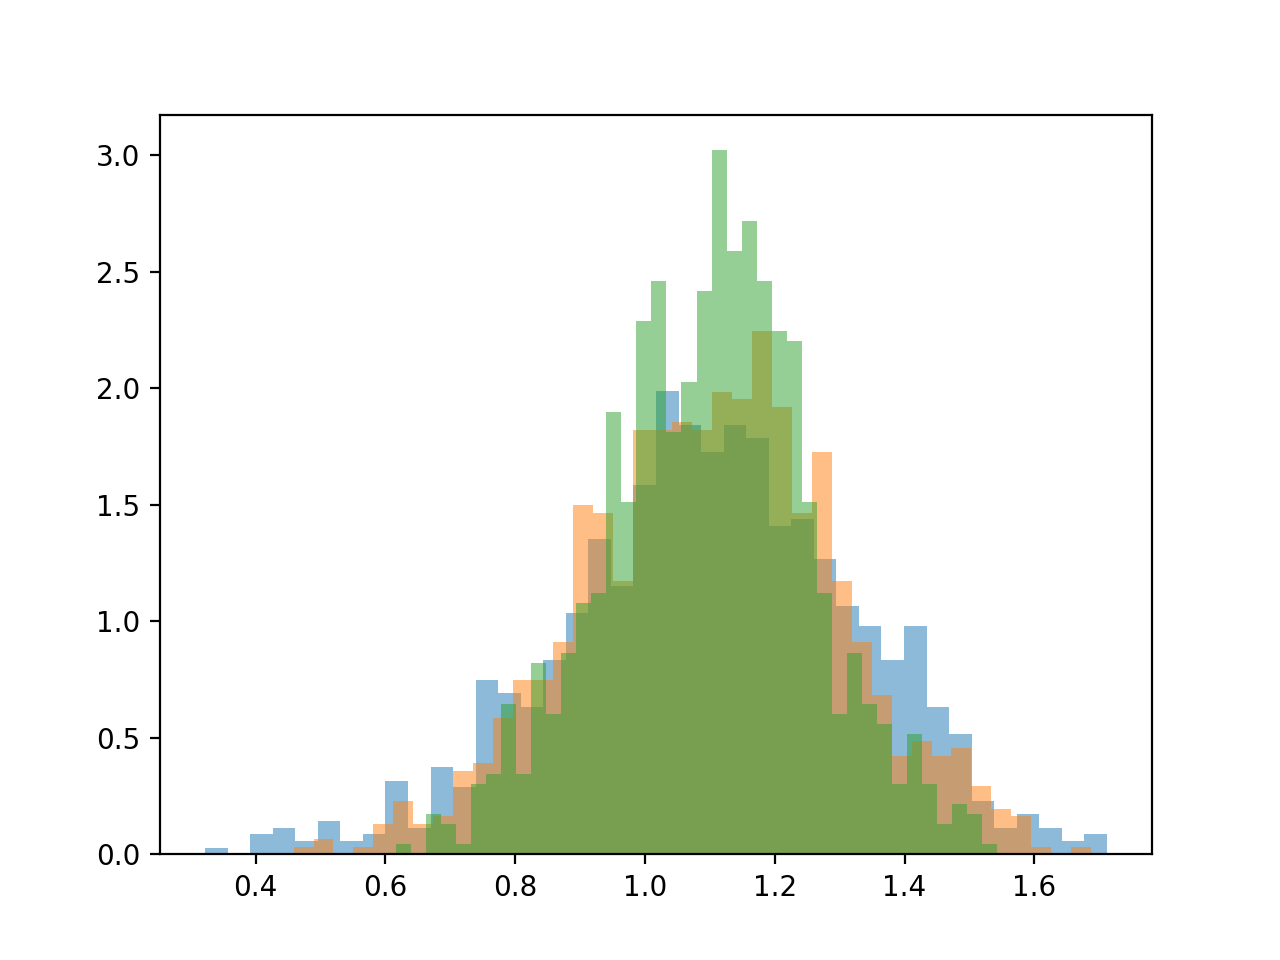

(array([0.04315255, 0.        , 0.17261022, 0.12945766, 0.04315255,
        0.30206788, 0.34522044, 0.64728832, 0.34522044, 0.81989854,
        0.60413577, 0.8630511 , 1.07881387, 1.12196643, 1.89871241,
        1.51033942, 2.28708541, 2.45969563, 1.8124073 , 2.02817008,
        2.41654307, 3.02067884, 2.58915329, 2.71861096, 2.45969563,
        2.24393285, 2.2007803 , 1.51033942, 1.12196643, 0.60413577,
        0.8630511 , 0.64728832, 0.56098321, 0.30206788, 0.51783066,
        0.30206788, 0.12945766, 0.21576277, 0.17261022, 0.04315255]),
 array([0.61595482, 0.63912842, 0.66230201, 0.68547561, 0.70864921,
        0.73182281, 0.75499641, 0.77817001, 0.80134361, 0.82451721,
        0.84769081, 0.8708644 , 0.894038  , 0.9172116 , 0.9403852 ,
        0.9635588 , 0.9867324 , 1.009906  , 1.0330796 , 1.0562532 ,
        1.0794268 , 1.10260039, 1.12577399, 1.14894759, 1.17212119,
        1.19529479, 1.21846839, 1.24164199, 1.26481559, 1.28798919,
        1.31116278, 1.33433638, 1.35750998, 1.

In [37]:
f,ax = plt.subplots()
ax.hist(np.array(all_targ),bins=40, density=True, alpha=.5)
ax.hist(np.array(all_pred),bins=40, density=True, alpha=.5)
ax.hist(np.array(sensor_means),bins=40, density=True, alpha=.5)

results senseiver: 
R^2: 0.36965673709901714
MAE: 4.719827175140381
RMSE: 6.7287678718566895
results average: 
R^2: 0.5165621491013807
MAE: 4.066159191622819
RMSE: 5.892740313401


<IPython.core.display.Javascript object>


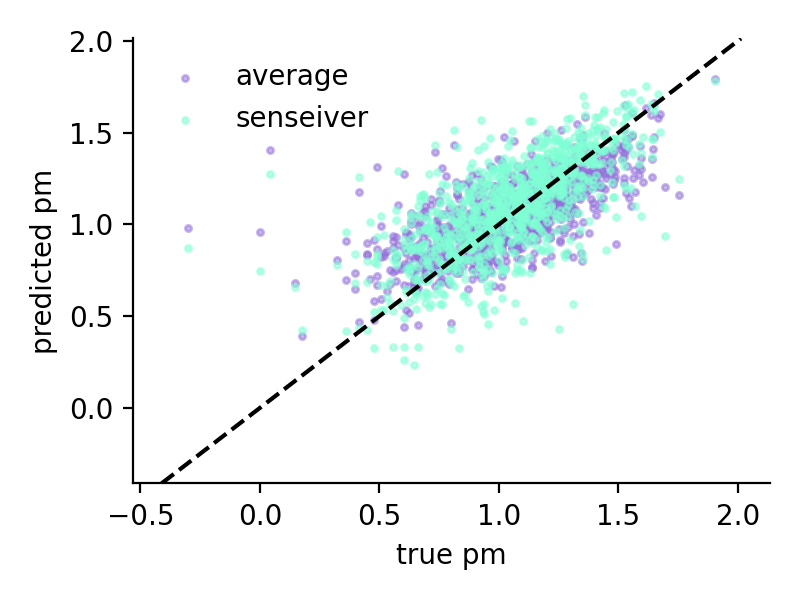

In [63]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# data_config['data_path'] = '../data/processed/daily_pm_southeast.pickle'
data_config['data_path'] = '../data/processed/processed_pm25_gridmet_eastern.csv'

dataloader = senseiver_dataloader(data_config, num_workers=4)
sensors, query_coords, targets = dataloader.dataset[0]
model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))


all_pred = []
all_targ = []
sensor_means = []
#all_positions = np.array([[0,0,0]])
for i in range(1000):
    with torch.no_grad():
        sensors, query_coords, targets = dataloader.dataset[i]
        query_coords = query_coords[0,:].unsqueeze(0)
        targets = targets[0,:]
        sensor_means+=[sensors[:,0].mean().detach().item()]
        out = model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))
        all_pred += list(out.detach().cpu().numpy().ravel())
        # all_pred += list(out.detach().cpu().numpy().ravel() + sensors[:,0].mean().detach().item())

        # all_targ += list(targets.reshape(2,1).numpy().ravel())
        all_targ += list(targets.numpy().ravel())


all_targ = np.array(all_targ)
all_pred = np.array(all_pred)
sensor_means = np.array(sensor_means)

print('results senseiver: ')
print('R^2: {0}'.format(r2_score(10**all_targ,10**all_pred)))
print('MAE: {0}'.format(mean_absolute_error(10**all_targ,10**all_pred)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(10**all_targ,10**all_pred))))

print('results average: ')
print('R^2: {0}'.format(r2_score(10**all_targ,10**sensor_means)))
print('MAE: {0}'.format(mean_absolute_error(10**all_targ,10**sensor_means)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(10**all_targ,10**sensor_means))))

f,ax = plt.subplots(figsize=(4,3))
ax.scatter(all_targ,sensor_means, s=5, alpha=.5, c='mediumpurple')

ax.scatter(all_targ,all_pred, s=5, alpha=.5, c='aquamarine')
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(),ax.get_xlim(),'k--')
ax.set_xlabel('true pm')
ax.set_ylabel('predicted pm')
ax.legend(['average','senseiver'],frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.tight_layout()

# Uncertainty quantification by clamping query position

results senseiver: 
R^2: 0.0
MAE: 3.501208782196045
RMSE: 4.236287593841553
results average: 
R^2: 0.0
MAE: 3.104991990353275
RMSE: 3.680039627006003


<IPython.core.display.Javascript object>


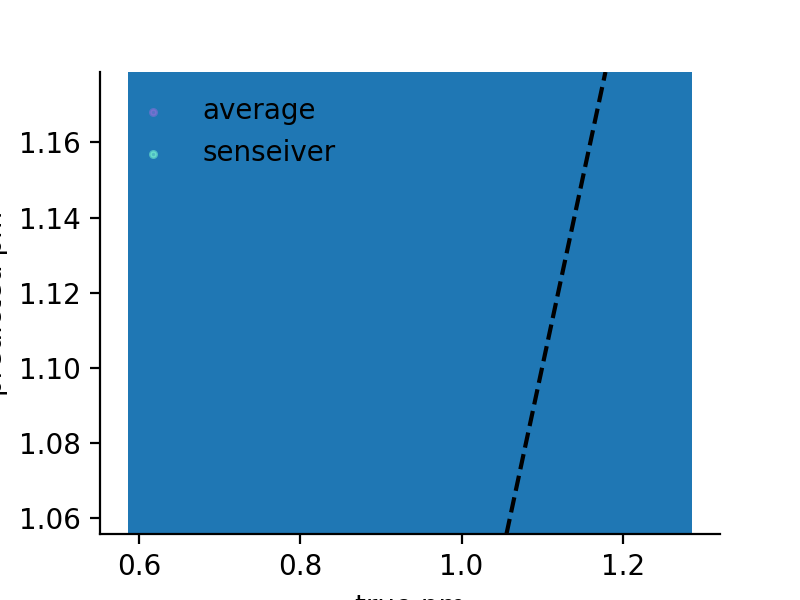

In [49]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# data_config['data_path'] = '../data/processed/daily_pm_southeast.pickle'
data_config['data_path'] = '../data/processed/processed_pm25_gridmet.csv'

dataloader = senseiver_dataloader(data_config, num_workers=4)
sensors, query_coords, targets = dataloader.dataset[0]
model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))


all_pred = []
all_targ = []
sensor_means = []
#all_positions = np.array([[0,0,0]])
sensors, query_coords, targets = dataloader.dataset[0]
query_coords = query_coords[0,:].unsqueeze(0)
targets = targets[0,:]
for i in range(100):
    with torch.no_grad():
        sensors, _, _ = dataloader.dataset[i]

        sensor_means+=[sensors[:,0].mean().detach().item()]
        out = model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))
        all_pred += list(out.detach().cpu().numpy().ravel())
        # all_pred += list(out.detach().cpu().numpy().ravel() + sensors[:,0].mean().detach().item())

        # all_targ += list(targets.reshape(2,1).numpy().ravel())
        all_targ += list(targets.numpy().ravel())


all_targ = np.array(all_targ)
all_pred = np.array(all_pred)
sensor_means = np.array(sensor_means)

print('results senseiver: ')
print('R^2: {0}'.format(r2_score(10**all_targ,10**all_pred)))
print('MAE: {0}'.format(mean_absolute_error(10**all_targ,10**all_pred)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(10**all_targ,10**all_pred))))

print('results average: ')
print('R^2: {0}'.format(r2_score(10**all_targ,10**sensor_means)))
print('MAE: {0}'.format(mean_absolute_error(10**all_targ,10**sensor_means)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(10**all_targ,10**sensor_means))))

f,ax = plt.subplots(figsize=(4,3))
ax.scatter(all_targ,sensor_means, s=5, alpha=.5, c='mediumpurple')

ax.scatter(all_targ,all_pred, s=5, alpha=.5, c='aquamarine')
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(),ax.get_xlim(),'k--')
ax.set_xlabel('true pm')
ax.set_ylabel('predicted pm')
ax.legend(['average','senseiver'],frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

<IPython.core.display.Javascript object>


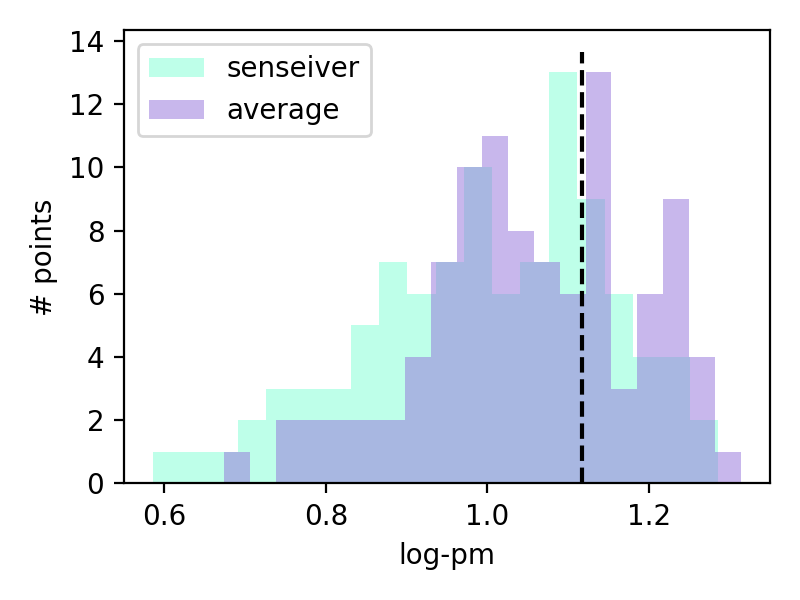

In [61]:
f,ax = plt.subplots(figsize=(4,3))
ax.hist(all_pred, bins=20, color='aquamarine',alpha=.5)
ax.hist(sensor_means, bins=20, color='mediumpurple',alpha=.5)
ax.legend(['senseiver','average'])
ax.plot([all_targ[-1], all_targ[-1]],ax.get_ylim(),'k--')
ax.set_xlabel('log-pm')
ax.set_ylabel('# points')
f.tight_layout()

results senseiver: 
R^2: 0.7448609993886596
MAE: 2.1184685230255127
RMSE: 2.7961478233337402
results average: 
R^2: 0.2741830096411332
MAE: 3.2897141933441163
RMSE: 4.716124624882461


<IPython.core.display.Javascript object>


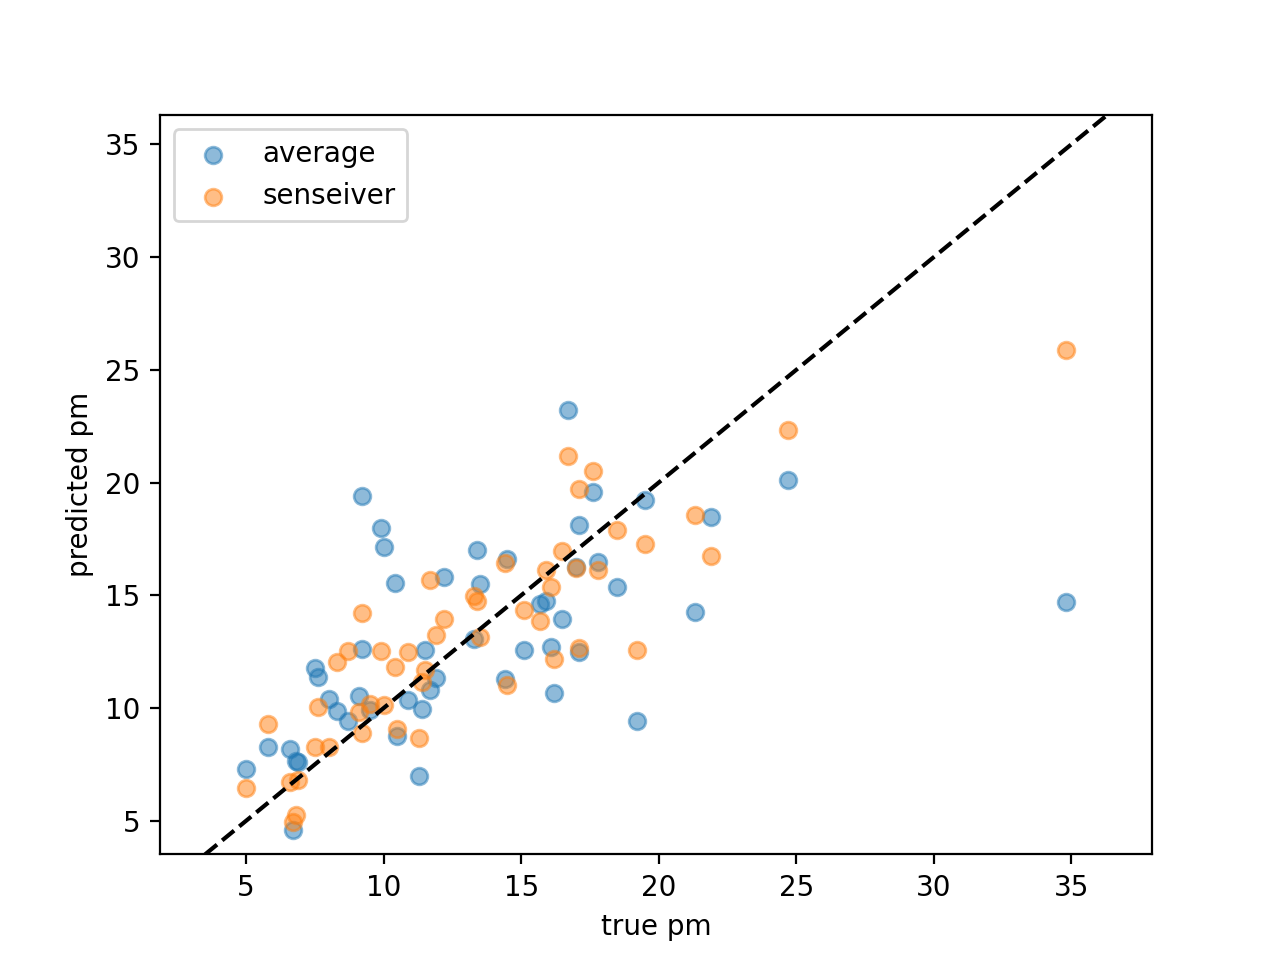

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# data_config['data_path'] = '../data/processed/daily_pm_southeast.pickle'
data_config['data_path'] = '../data/processed/processed_pm25_gridmet.csv'
data_config['split'] = 'val'

dataloader = senseiver_dataloader(data_config, num_workers=4)
sensors, query_coords, targets = dataloader.dataset[0]
model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))


all_pred = []
all_targ = []
sensor_means = []
#all_positions = np.array([[0,0,0]])
for i in range(50):
    with torch.no_grad():
        sensors, query_coords, targets = dataloader.dataset[i]
        query_coords = query_coords[0,:].unsqueeze(0)
        targets = targets[0,:]
        sensor_means+=[sensors[:,0].mean().detach().item()]
        out = model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))
        all_pred += list(out.detach().cpu().numpy().ravel())
        # all_pred += list(out.detach().cpu().numpy().ravel() + sensors[:,0].mean().detach().item())

        # all_targ += list(targets.reshape(2,1).numpy().ravel())
        all_targ += list(targets.numpy().ravel())


print('results senseiver: ')
print('R^2: {0}'.format(r2_score(all_targ,all_pred)))
print('MAE: {0}'.format(mean_absolute_error(all_targ,all_pred)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(all_targ,all_pred))))

print('results average: ')
print('R^2: {0}'.format(r2_score(all_targ,sensor_means)))
print('MAE: {0}'.format(mean_absolute_error(all_targ,sensor_means)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(all_targ,sensor_means))))

f,ax = plt.subplots()
ax.scatter(all_targ,sensor_means, alpha=.5)

ax.scatter(all_targ,all_pred, alpha=.5)
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(),ax.get_xlim(),'k--')
ax.set_xlabel('true pm')
ax.set_ylabel('predicted pm')
ax.legend(['average','senseiver'])

R^2: -0.14132128730854698
MAE: 7.512181282043457
RMSE: 9.932528495788574


<IPython.core.display.Javascript object>


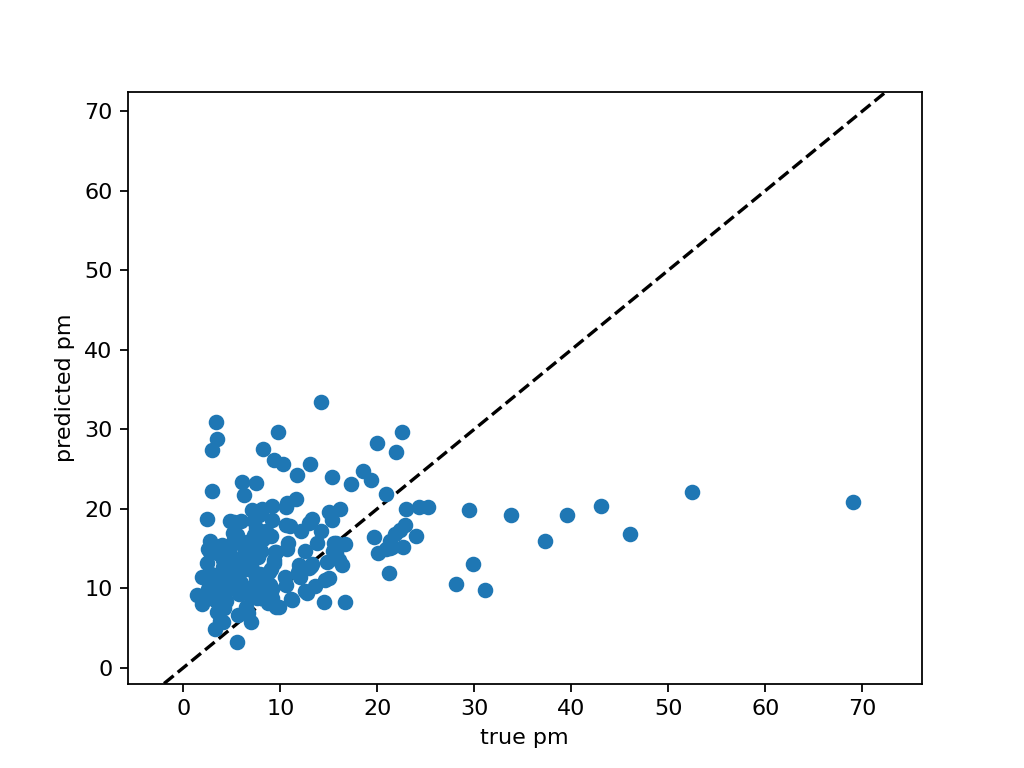

Text(0, 0.5, 'predicted pm')

In [7]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

data_config['data_path'] = '../data/processed/daily_pm_northeast.pickle'
dataloader = senseiver_dataloader(data_config, num_workers=4)
sensors, query_coords, targets = dataloader.dataset[0]
model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))


all_pred = []
all_targ = []
#all_positions = np.array([[0,0,0]])
for i in range(100):
    with torch.no_grad():
        sensors, query_coords, targets = dataloader.dataset[i]
        out = model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))
        all_pred += list(out.detach().cpu().numpy().ravel())
        all_targ += list(targets.reshape(2,1).numpy().ravel())


print('R^2: {0}'.format(r2_score(all_targ,all_pred)))
print('MAE: {0}'.format(mean_absolute_error(all_targ,all_pred)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(all_targ,all_pred))))

f,ax = plt.subplots()
ax.scatter(all_targ,all_pred)
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(),ax.get_xlim(),'k--',zorder=-1)
ax.set_xlabel('true pm')
ax.set_ylabel('predicted pm')
       # all_positions = np.vstack([all_positions, sensors[:,1:].detach().cpu().numpy()])
#         f,ax = plt.subplots(figsize=(3,2))
#         ax.scatter(sensors[:,1],sensors[:,2],c='k')
#         ax.scatter(query_coords[:,0],query_coords[:,1],c='r')
# all_positions = all_positions[1:,:]
                            

R^2: -0.12701918630107745
MAE: 8.567745208740234
RMSE: 11.188204765319824


<IPython.core.display.Javascript object>


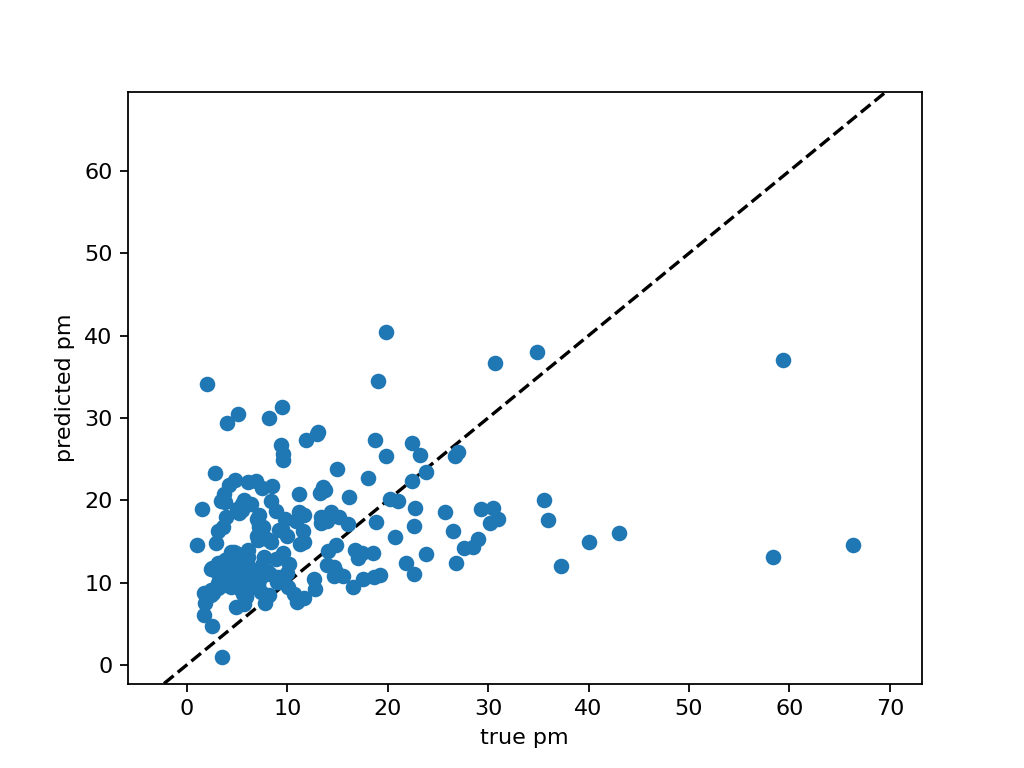

Text(0, 0.5, 'predicted pm')

In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

data_config['data_path'] = '../data/processed/daily_pm_west.pickle'
dataloader = senseiver_dataloader(data_config, num_workers=4)
sensors, query_coords, targets = dataloader.dataset[0]
model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))


all_pred = []
all_targ = []
#all_positions = np.array([[0,0,0]])
for i in range(100):
    with torch.no_grad():
        sensors, query_coords, targets = dataloader.dataset[i]
        out = model(sensors.to('mps').unsqueeze(0),query_coords.to('mps').unsqueeze(0))
        all_pred += list(out.detach().cpu().numpy().ravel())
        all_targ += list(targets.reshape(2,1).numpy().ravel())


print('R^2: {0}'.format(r2_score(all_targ,all_pred)))
print('MAE: {0}'.format(mean_absolute_error(all_targ,all_pred)))
print('RMSE: {0}'.format(np.sqrt(mean_squared_error(all_targ,all_pred))))

f,ax = plt.subplots()
ax.scatter(all_targ,all_pred)
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(),ax.get_xlim(),'k--',zorder=-1)
ax.set_xlabel('true pm')
ax.set_ylabel('predicted pm')
       # all_positions = np.vstack([all_positions, sensors[:,1:].detach().cpu().numpy()])
#         f,ax = plt.subplots(figsize=(3,2))
#         ax.scatter(sensors[:,1],sensors[:,2],c='k')
#         ax.scatter(query_coords[:,0],query_coords[:,1],c='r')
# all_positions = all_positions[1:,:]

In [14]:
np.array(all_pred).shape

(200,)

<IPython.core.display.Javascript object>


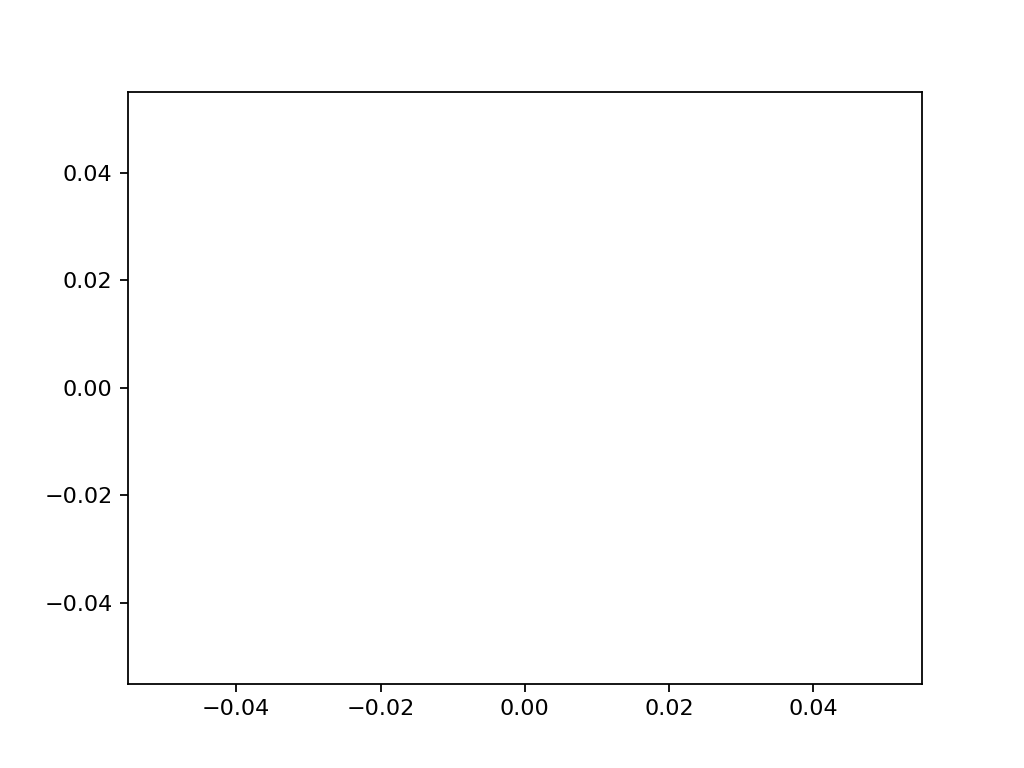

In [49]:
f,ax = plt.subplots()
ax.scatter(all_positions[:,0],all_positions[:,1])

In [91]:
all_positions[:8]

array([[0.05976598, 0.01581315, 0.00254237],
       [0.38489491, 0.71015054, 0.16101696],
       [0.77455598, 0.26370904, 0.21610169],
       [0.05577273, 0.72716594, 0.22542372],
       [0.21631289, 0.65631616, 0.15762712],
       [0.63303822, 0.72571367, 0.18644068],
       [0.49938893, 0.1367422 , 0.06271186],
       [0.75991648, 0.26855254, 0.24915254]])

<IPython.core.display.Javascript object>


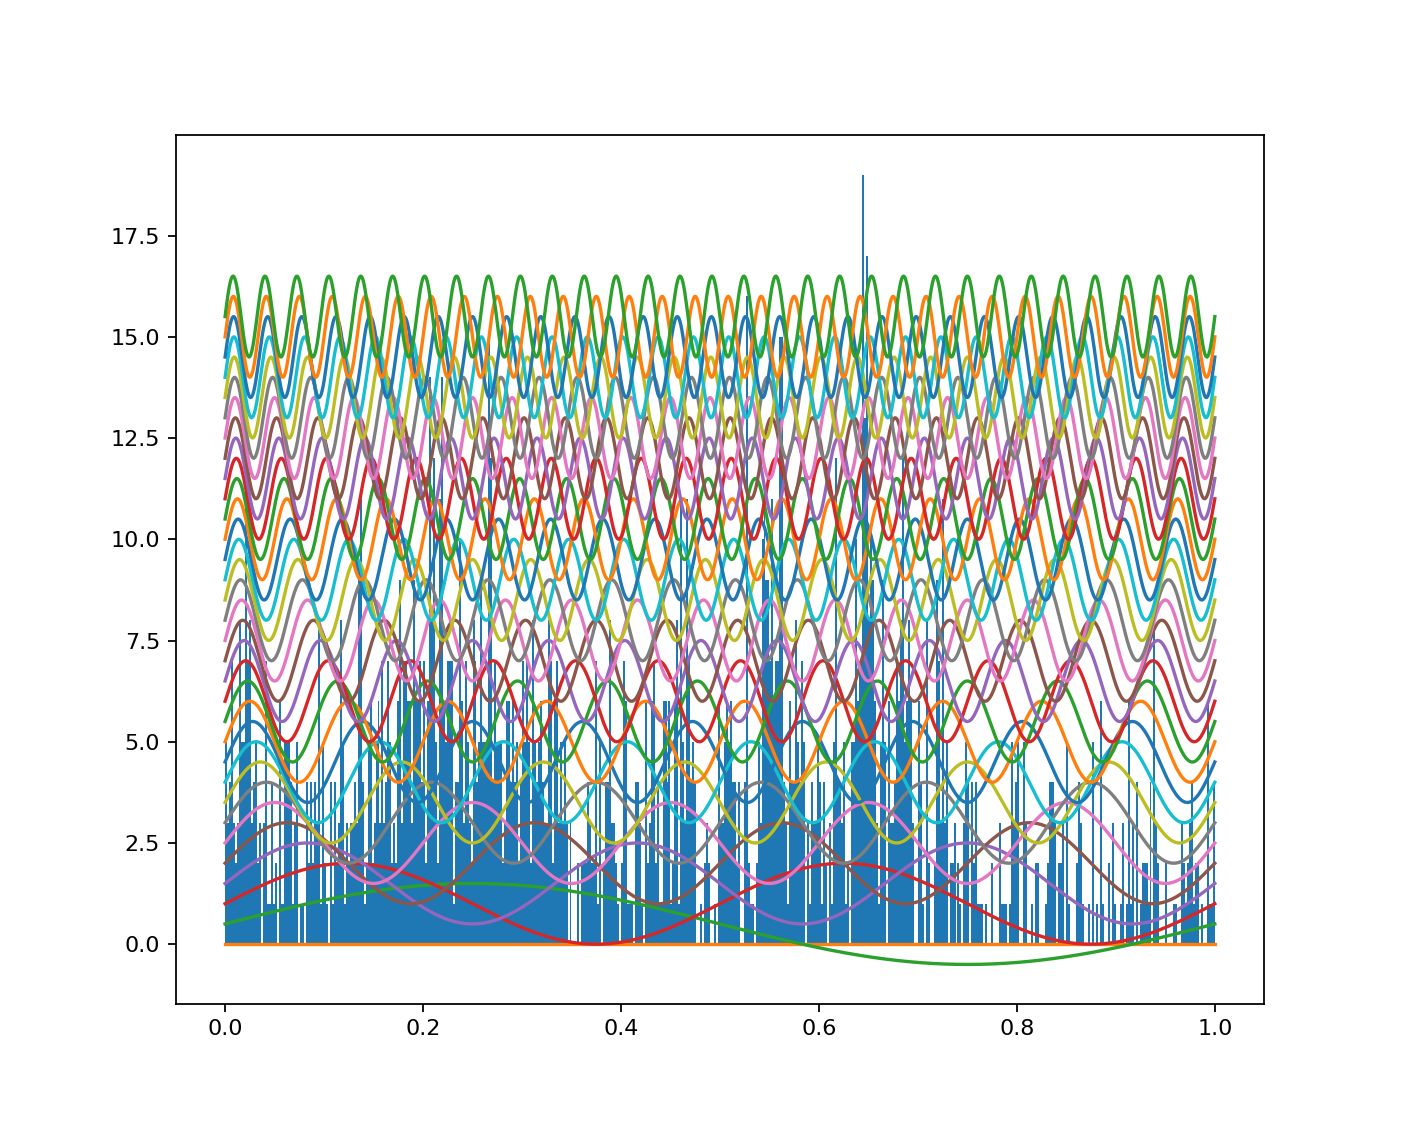

In [58]:
f,ax = plt.subplots()
x = np.linspace(0,1,1000)
ax.hist(raw_pos,bins=500)
freqs = np.arange(32)
for i,freq in enumerate(freqs):
    max_wave = np.sin(2*np.pi*freq*x)
    ax.plot(x,max_wave*1+i*.5)



In [45]:
# load raw data
import pickle
with open('../data/processed/daily_pm_southeast.pickle', 'rb') as f:
    raw_data = pickle.load(f)
    
raw_pos = np.unique(raw_data['position'])

In [72]:
import numpy as np

def fourier_decomposition(number, frequencies):
    """
    Perform Fourier decomposition of a number onto a set of frequencies using sines and cosines.

    Parameters:
        number (float): The number to be decomposed.
        frequencies (list of float): The frequencies onto which the number will be decomposed.

    Returns:
        decomposition (dict): A dictionary mapping each frequency to its corresponding coefficient in the decomposition.
    """
    decomposition = {}
    for freq in frequencies:
        cos_coefficient = np.cos(2 * np.pi * freq) * number
        sin_coefficient = np.sin(2 * np.pi * freq) * number
        decomposition[freq] = {'cos': cos_coefficient, 'sin': sin_coefficient}
    return decomposition

# Example usage:
number = 5
frequencies = [1, 2, 3]  # Frequencies to decompose onto
result = fourier_decomposition(number, frequencies)
print(result)

{1: {'cos': 5.0, 'sin': -1.2246467991473533e-15}, 2: {'cos': 5.0, 'sin': -2.4492935982947065e-15}, 3: {'cos': 5.0, 'sin': -3.673940397442059e-15}}
